## Planetary radiation
Now that we learned how to compute the SRP for complex shapes, accounting for secondary reflections, diffusion, eclipses, etc
it's time to learn how to set up the calculation of Albedo and Thermal Infrared pressure exerted by solar system bodies 
on the spacecraft. 


First of all let's create a spacecraft and a planet. We'll use the same spacecraft (capsule) as the previous example
so that we can reuse the LUT we have already computed. 

In [1]:
import trimesh as tm
import spiceypy as sp
import numpy as np
from pyRTX.classes.SRP import SolarPressure
from pyRTX.classes.Planet import Planet
from pyRTX.classes.Spacecraft import Spacecraft

# We'll load some SPICE kernels for simplicity
METAKR = '../example_data/LRO/metakernel_lro.tm'     # metakernel
sp.furnsh(METAKR)  # Load the metakernel containing references to the necessary SPICE frames

# Create a simple spacecraft (a capsule/cylinder)
sc = tm.creation.capsule(height = 3, radius = 1, count = [9,9], )
sc_model = {
    'BUS':{
    'file' : sc,
    'frame_type': 'Spice',
    'frame_name': 'LRO_SC_BUS',
    'center' : [0,0,0], 
    'specular': 0.3, 
    'diffuse' : 0,
    }}

sc = Spacecraft(
                name = 'LRO', 
                base_frame = 'LRO_SC_BUS', 
                mass = 2000,
                spacecraft_model = sc_model, 
                units = 'm')


There are different ways of creating a planet. 

For example we can create a spherical planet, or we can load an .obj of its elevation. 
In case we provide an .obj, this should represent variations around a reference radius, that is an input. 

In [2]:
# Create a simple spherical planet
ref_radius  =  1737.4
moon = Planet(  fromFile      = None, # If None a sphere will be used
                radius        = ref_radius, # This is the radius of the sphere
                name          = 'Moon', 
                bodyFrame     = 'MOON_ME', # Moon body-fixed frame
                sunFixedFrame = 'GSE_MOON', # Sun-fixed frame (more details in the albedo example)
                units         = 'km',
                subdivs       = 6, # How detailed the sphere will be (this is an input to trimesh.creation.icosphere
                )                  # see trimesh documentation for more details)

You'll have noticed that we had to define two frames:
1) The body fixed frame: this is the conventional body fixed frame that defines the orientation of the body in space.
   for the Moon we use the "Mean Earth" frame (MOON_ME)
2) Albedo calculations greatly simplify if performed in a reference frame where the Sun is fixed. We can easily define it and
   load it in the METAKR file.

Here is how we defined it for the moon (GSE_MOON)

```
KPL/FK

\begindata

      FRAME_GSE_MOON                =  1500301
      FRAME_1500301_NAME            = 'GSE_MOON'
      FRAME_1500301_CLASS           =  5
      FRAME_1500301_CLASS_ID        =  1500301
      FRAME_1500301_CENTER          =  301
      FRAME_1500301_RELATIVE        = 'J2000'
      FRAME_1500301_DEF_STYLE       = 'PARAMETERIZED'
      FRAME_1500301_FAMILY          = 'TWO-VECTOR'
      FRAME_1500301_PRI_AXIS        = 'X'
      FRAME_1500301_PRI_VECTOR_DEF  = 'OBSERVER_TARGET_POSITION'
      FRAME_1500301_PRI_OBSERVER    = 'MOON'
      FRAME_1500301_PRI_TARGET      = 'SUN'
      FRAME_1500301_PRI_ABCORR      = 'NONE'
      FRAME_1500301_SEC_AXIS        = 'Y'
      FRAME_1500301_SEC_VECTOR_DEF  = 'OBSERVER_TARGET_VELOCITY'
      FRAME_1500301_SEC_OBSERVER    = 'MOON'
      FRAME_1500301_SEC_TARGET      = 'SUN'
      FRAME_1500301_SEC_ABCORR      = 'NONE'
      FRAME_1500301_SEC_FRAME       = 'J2000'

      NAIF_BODY_NAME += ( 'GSE_MOON' )
      NAIF_BODY_CODE += (  1500301   )

\begintext
```

Now we need to define the physical properties of the Moon, namely we must define 
1) Albedo
2) Infrared emissivity
3) Temperature

There are several ways for doing this in pyRTX and we will now look at all of them.

We'll start with the simplest one, that is assigning constant properties:

In [3]:
moon.albedo = 0.15
moon.emissivity = 0.9
moon.dayside_temperature = 300
moon.nightside_temperature = 200

Setting a single value of albedo for all the faces
Setting a single value of emissivity for all the faces


Pretty simple isn't it? 
Let's visualize it (by default the mesh will be visualized in the body fixed frame).

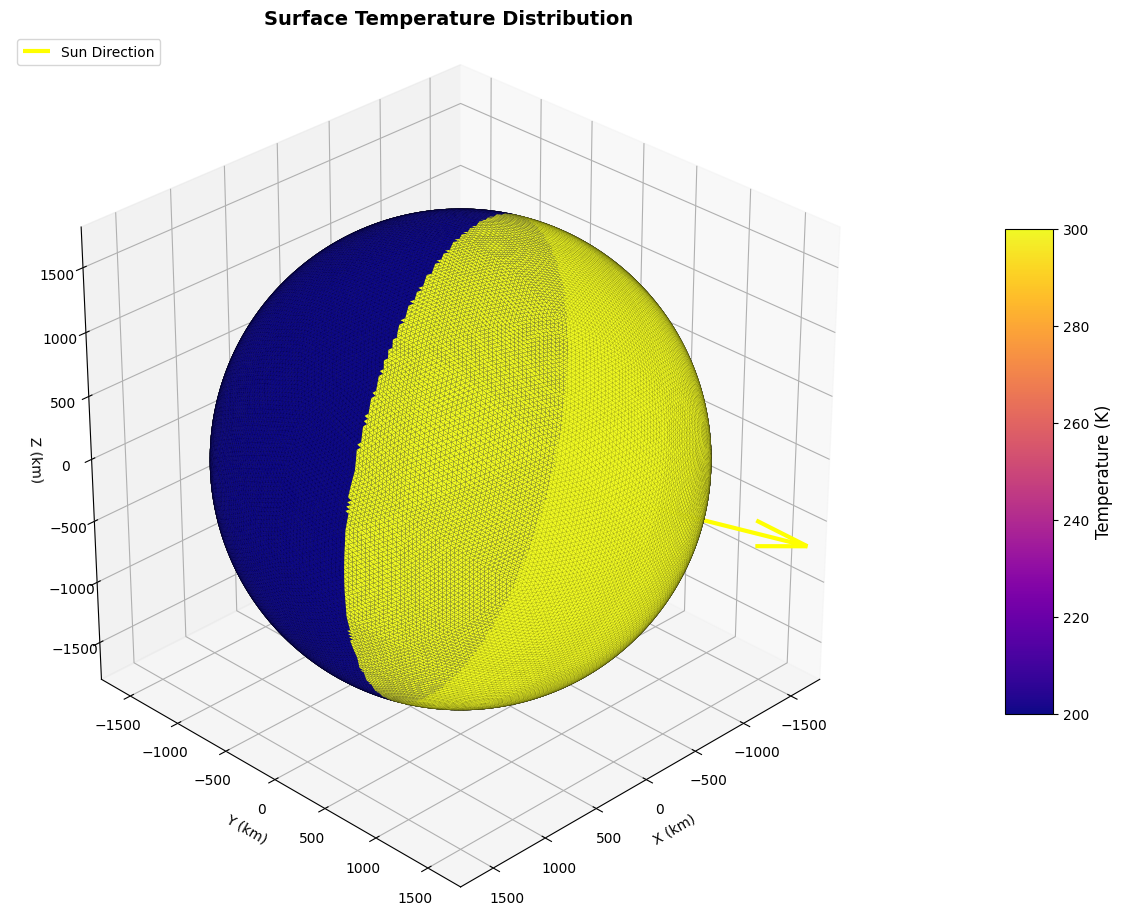

In [4]:
from pyRTX.visual.utils import visualize_planet_field
epoch = '01-JAN-2020 12:00'
epoch = sp.str2et(epoch)

# Let's visualize the only interesting field, as the other ones are constant
visualize_planet_field(moon, field = 'temperature', epoch = epoch, show_sun = True);


We can, however, do something more interesting, that is: we can define spatially variable fields of these quantities


In [5]:
from pyRTX.classes.Planet import AlbedoGrid, TemperatureGrid
alb_grid = '../examples/grids/bond_albedo.npy'  
alb_lon  = '../examples/grids/ldam_4_lon.npy'
alb_lat  = '../examples/grids/ldam_4_lat.npy'

temp_grid = '../examples/grids/temp.npy'  
temp_lon  = '../examples/grids/temp_lon.npy'
temp_lat  = '../examples/grids/temp_lat.npy'

# Define the Albedo grid object
Lon = np.load(alb_lon)
Lat = np.load(alb_lat)

ALB = AlbedoGrid(
		radius      = ref_radius,
		frame       = 'MOON_ME',
		planet_name = 'Moon',
		from_array  = alb_grid,
		axes        = (Lon, Lat),
		)

# Define the temperature grid object
Lon = np.load(temp_lon)
Lat = np.load(temp_lat)

TEMP = TemperatureGrid(
		radius      = ref_radius,
		frame       = 'GSE_MOON',
		planet_name = 'Moon',
		from_array  = temp_grid,
		axes        = (Lon, Lat),
		)


moon.emissivity          = 0.9
moon.albedo              = ALB
moon.gridded_temperature = TEMP

Setting a single value of emissivity for all the faces


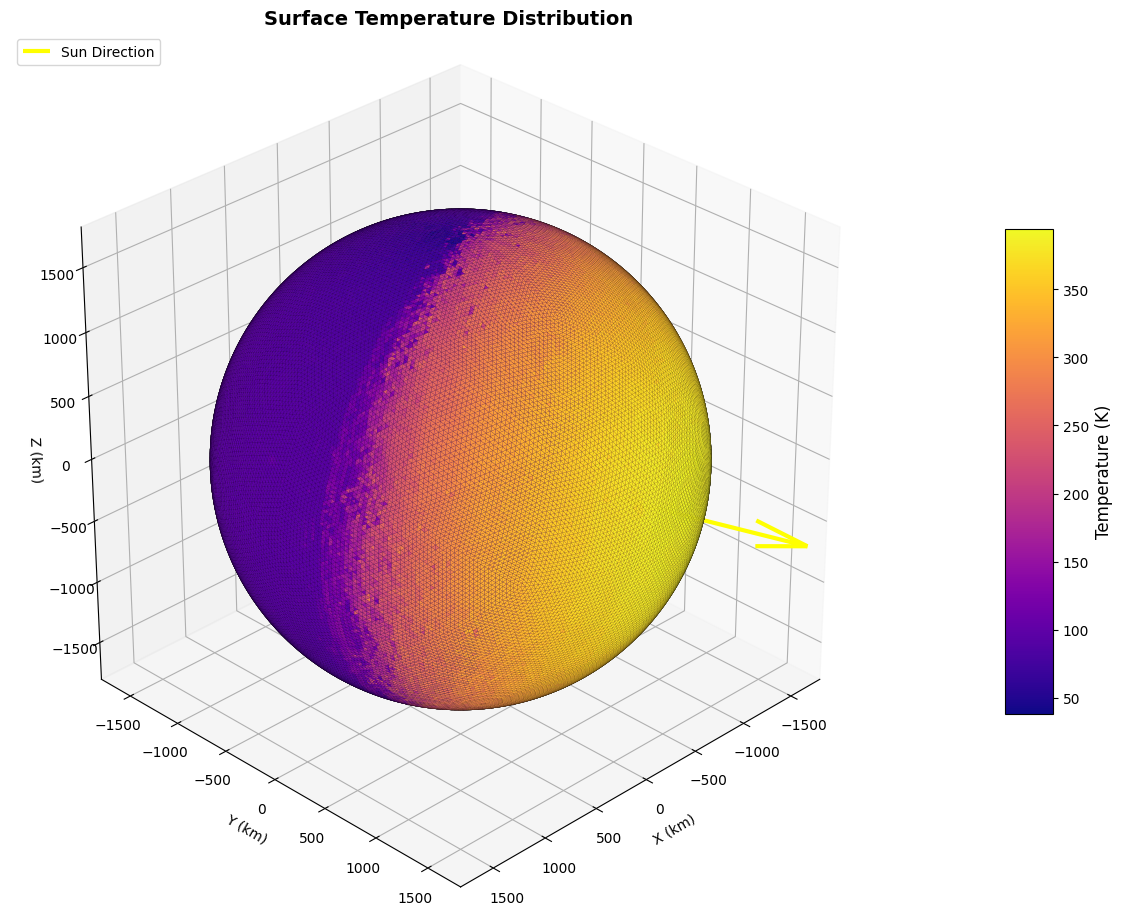

In [6]:
# Now we can visualize the spatially varying temperature field
visualize_planet_field(moon, field = 'temperature', epoch = epoch, show_sun = True);

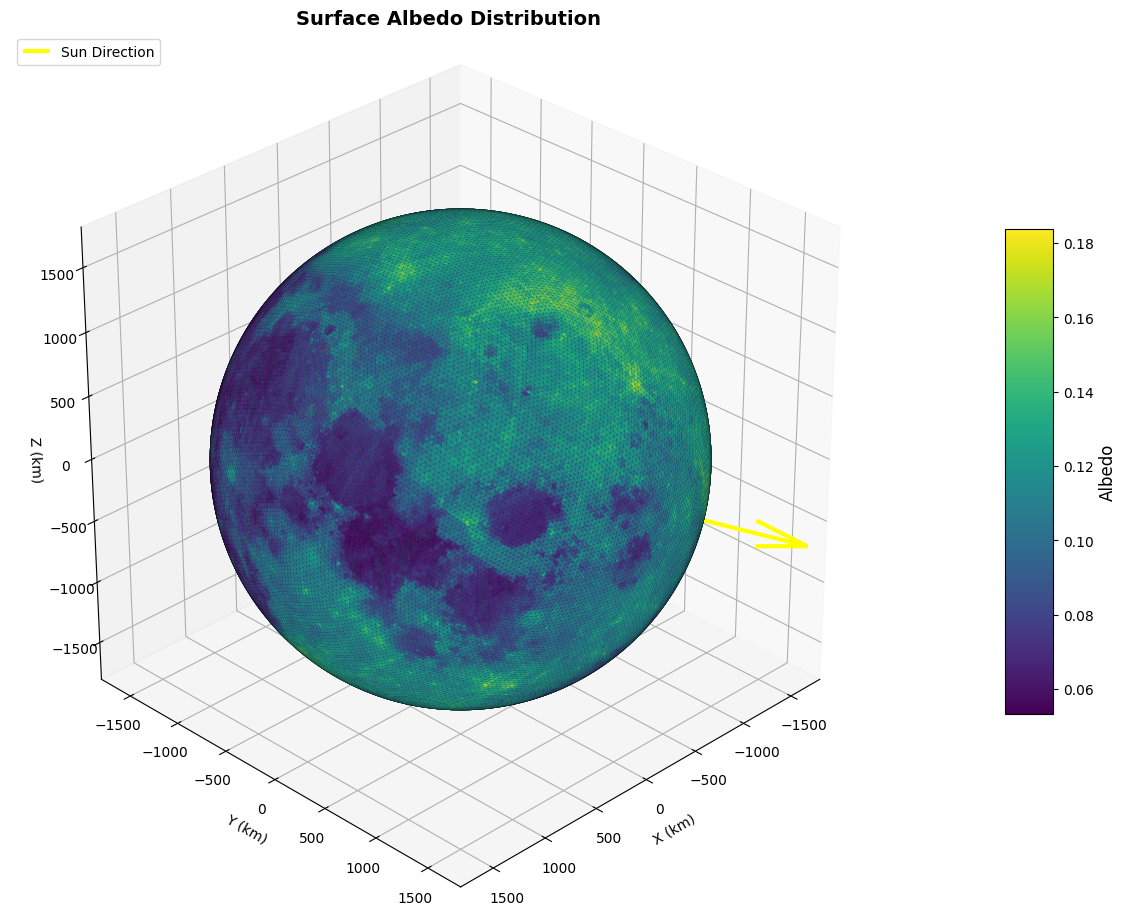

In [7]:
# Now we can visualize the spatially varying albedo field
visualize_planet_field(moon, field = 'albedo', epoch = epoch, show_sun = True);

Now that we learned to input physical properties into the Planet object, we can use it to run calculations. 
The way that Albedo and Thermal Infrared calculations are set up in pyRTX leverages ray tracing.

The code first computes all the facets of the Planet that are in view of the spacecraft, then traces a ray
for every surface, directed to the spacecraft. 
This mean that there will be thousands (or millions) of rays impacting the spacecraft from many different directions in the spacecraft body frame.
For this reason it would be very inefficient to run these computations "live". For these quantities we can use the **LUT** we have computed and saved in the previous example!

In [8]:
from pyRTX.classes.LookUpTable import LookUpTable 
from pyRTX.classes.Radiation import Albedo, Emissivity
from pyRTX.classes.Precompute import Precompute
from pyRTX.core.analysis_utils import epochRange2
from pyRTX.classes.SRP import SolarPressure


# Define a set of epochs on which we want to perform the computation
ref_epc		= "2010 may 10 09:25:00"
duration    = 5000  								
timestep    = 50
epc_et0  = sp.str2et( ref_epc )
epc_et1  = epc_et0 + duration
epochs   = epochRange2(startEpoch = epc_et0, endEpoch = epc_et1, step = timestep)


LUT = LookUpTable('capsule_lut.nc')
base_flux = 1361.7
n_cores = 3

# Precomputation object
prec = Precompute(epochs = epochs,)
prec.precomputePlanetaryRadiation(sc, moon,)
prec.dump()


# Create the albedo object
albedo = Albedo(sc, LUT, moon, precomputation  = prec, baseflux  = base_flux,)

# Create the thermal infrared object
thermal_ir = Emissivity(sc, LUT, moon, precomputation  = prec, baseflux  = base_flux,)


# Run the computations
alb_accel = albedo.compute(epochs, n_cores = n_cores)[0] * 1e3 
ir_accel  = thermal_ir.compute(epochs, n_cores = n_cores)[0] * 1e3 


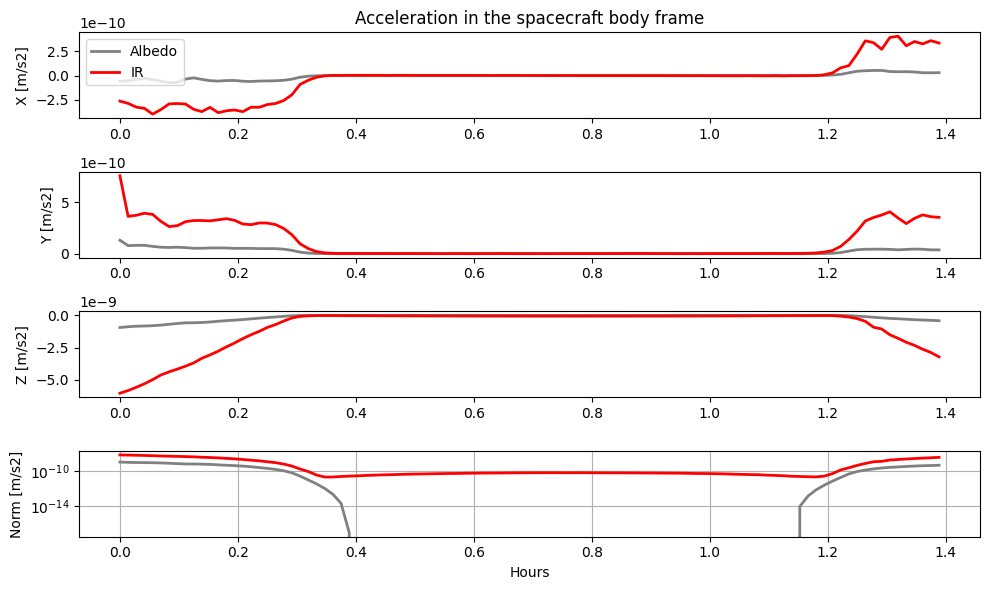

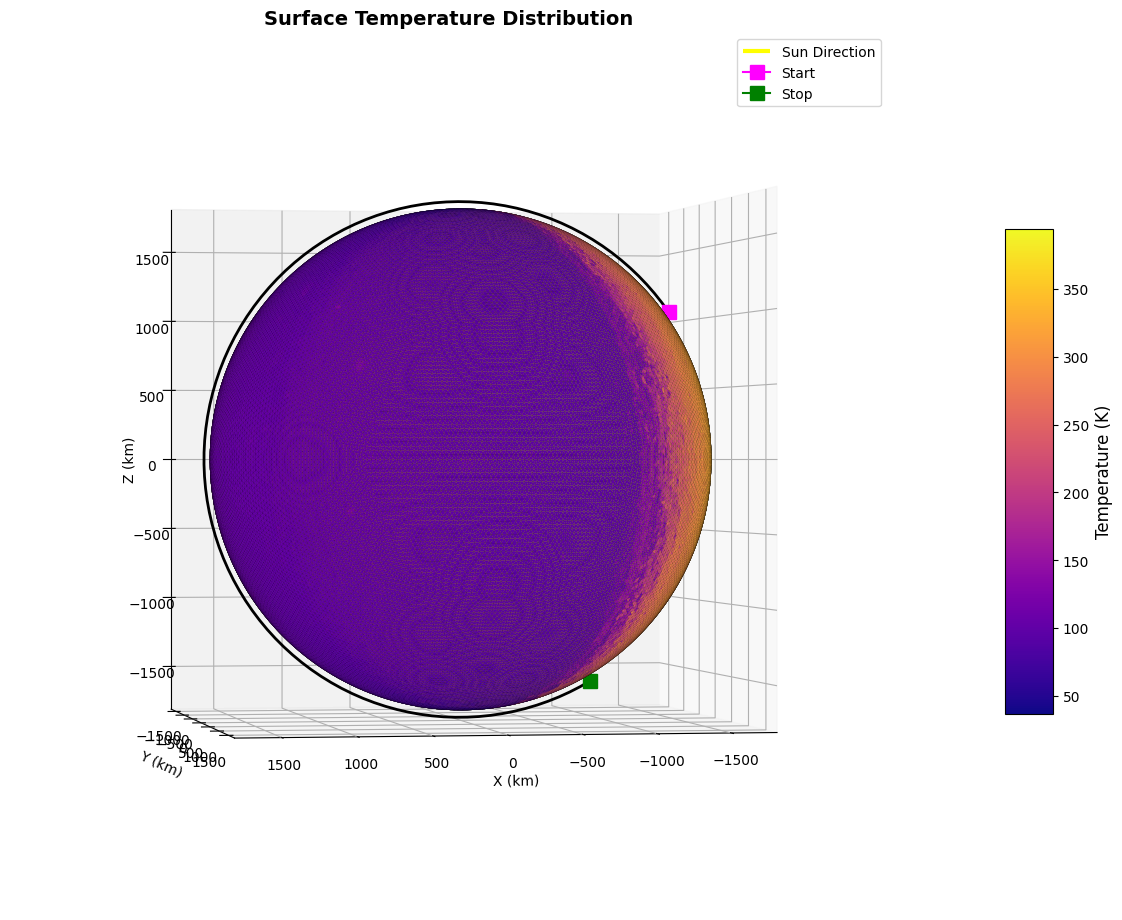

In [9]:
# Plot it
import matplotlib.pyplot as plt
eps = [(e - epochs[0])/3600 for e in epochs]
fig, ax = plt.subplots(4, 1, figsize = (10,6))
labels = ['X [m/s2]', 'Y [m/s2]', 'Z [m/s2]', 'Norm [m/s2]']
for i in range(3):
    ax[i].plot(eps, alb_accel[:, i], label = 'Albedo', color = 'gray', lw = 2)
    ax[i].plot(eps, ir_accel[:, i], label = 'IR', color = 'red', lw = 2)
    ax[i].set_ylabel(labels[i])
    
ax[3].plot(eps, np.linalg.norm(alb_accel, axis = 1),color = 'gray', lw = 2)
ax[3].plot(eps, np.linalg.norm(ir_accel, axis = 1), color = 'red', lw = 2)
ax[3].set_ylabel(labels[3])
ax[0].legend()
ax[3].set_xlabel('Hours')
ax[3].set_yscale('log')
ax[3].grid()
ax[0].set_title('Acceleration in the spacecraft body frame')
plt.tight_layout()


# Let's visualize also the spacecraft trajectory on top of the temperature field
fig, ax = visualize_planet_field(moon, field = 'temperature', epoch = epc_et0, show_sun = True, azim = 80, elev = 0);

# Get the spacecraft trajectory
from pyRTX.utilities import getScPosVel
pos, vel = getScPosVel('LRO','Moon', epochs, 'MOON_ME')

ax.plot(pos[:, 0], pos[:, 1], pos[:, 2], color = 'k', linewidth = 2)
ax.plot(pos[0, 0], pos[0, 1], pos[0, 2], color = 'magenta', marker = 's', markersize = 10, label = 'Start')
ax.plot(pos[-1, 0], pos[-1, 1], pos[-1, 2], color = 'green', marker = 's', markersize = 10, label = 'Stop')
ax.legend()

We can see that correctly, when the spacecrat is flying over the nightside (i.e., the albedo acceleration is 0), the thermal infrared emission continues to create pressure on the spacecraft. 